## 1. 환경 설정 및 라이브러리 로드

In [3]:
!pip install -q -U torch transformers peft bitsandbytes accelerate pandas datasets evaluate rouge_score scikit-learn matplotlib seaborn

In [19]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from collections import defaultdict
import json
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from evaluate import load as load_metric
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'

# 설정
CONF = {
    "base_model": "upstage/SOLAR-10.7B-Instruct-v1.0",
    "adapter_path": "./results_solar",
    "data_path": "./data/",
    "output_dir": "./grid_search_results",
    "eval_sample_size": 10,  # ⚡ 50 → 10으로 축소 (5배 빠름)
    "seed": 42
}

# 출력 디렉토리 생성
os.makedirs(CONF['output_dir'], exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")
print(f"✅ Eval sample size: {CONF['eval_sample_size']} (Dev subset for fast testing)")

✅ Using device: cuda
✅ Eval sample size: 10 (Dev subset for fast testing)


## 2. 모델 및 토크나이저 로드

In [20]:
# 4-bit 양자화 설정
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

print("Loading base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    CONF['base_model'],
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

print("Loading adapter...")
model = PeftModel.from_pretrained(base_model, CONF['adapter_path'])
model.eval()

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(CONF['base_model'], trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print("✅ Model, Adapter, and Tokenizer loaded successfully")

Loading base model...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loading adapter...
Loading tokenizer...
Loading tokenizer...
✅ Model, Adapter, and Tokenizer loaded successfully
✅ Model, Adapter, and Tokenizer loaded successfully


## 3. 데이터 로드 및 평가 함수

In [21]:
# 데이터 로드
dev_df = pd.read_csv(os.path.join(CONF['data_path'], 'dev.csv'))
test_df = pd.read_csv(os.path.join(CONF['data_path'], 'test.csv'))

# 그리드서치 평가용 Dev 부분집합
eval_df = dev_df.iloc[:CONF['eval_sample_size']].reset_index(drop=True)

print(f"✅ Dev set size: {len(dev_df)}")
print(f"✅ Eval subset size: {len(eval_df)} (for grid search)")
print(f"✅ Test set size: {len(test_df)}")

# ROUGE 메트릭 초기화
rouge = load_metric("rouge")

def compute_rouge(predictions, references):
    """ROUGE 점수 계산"""
    results = rouge.compute(predictions=predictions, references=references, use_stemmer=True)
    return {
        "rouge1": results["rouge1"].mid.fmeasure if hasattr(results["rouge1"], "mid") else results["rouge1"],
        "rouge2": results["rouge2"].mid.fmeasure if hasattr(results["rouge2"], "mid") else results["rouge2"],
        "rougeL": results["rougeL"].mid.fmeasure if hasattr(results["rougeL"], "mid") else results["rougeL"],
    }

def post_process(text):
    """후처리: 마지막 완전한 문장까지만"""
    if '.' in text:
        last_period = text.rfind('.')
        return text[:last_period + 1]
    return text

✅ Dev set size: 499
✅ Eval subset size: 10 (for grid search)
✅ Test set size: 499


## 4. 프롬프트 템플릿 정의

In [22]:
PROMPTS = {
    "basic": "### User:\nSummarize the following dialogue:\n\n{dialogue}\n\n### Assistant:\n",
    "korean": "### User:\n다음 대화를 한국어로 요약해줘:\n\n{dialogue}\n\n### Assistant:\n",
    "concise": "### User:\nSummarize the dialogue briefly in 2-3 sentences:\n\n{dialogue}\n\n### Assistant:\n",
    "detailed": "### User:\nProvide a detailed summary of the conversation:\n\n{dialogue}\n\n### Assistant:\n",
}

print(f"✅ Loaded {len(PROMPTS)} prompt templates")

✅ Loaded 4 prompt templates


## 5. 추론 함수 및 캐싱

In [23]:
# 캐싱 없이 매번 새로 추론 (파라미터별 정확한 결과 보장)

def run_inference(dialogue, prompt_template, params):
    """단일 추론 실행 (캐싱 없음 - 파라미터별 정확한 결과)"""
    
    prompt = prompt_template.format(dialogue=dialogue)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **params,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    try:
        summary = generated_text.split("### Assistant:\n")[1].strip()
    except:
        summary = generated_text
    
    return summary

print("✅ Inference function ready (no caching for accurate grid search)")

✅ Inference function ready (no caching for accurate grid search)


## 6. 그리드서치 설정

In [24]:
"""
⚡ 축소된 그리드서치 파라미터 공간 (현실적 시간 내 완료)

원래: 324 조합 × 50 샘플 = 16,200 추론 → 84시간
축소: 36 조합 × 10 샘플 = 360 추론 → 약 1-2시간
"""

GRID_SEARCH_SPACE = {
    "prompt_names": ["basic", "detailed"],  # 3 → 2개 (핵심만)
    "max_new_tokens": [128, 150],  # 3 → 2개
    "num_beams": [1, 3],  # 3 → 2개 (greedy vs beam)
    "no_repeat_ngram_size": [0, 3],  # 2개 유지
    "repetition_penalty": [1.0, 1.2],  # 2개 유지
    "length_penalty": [1.0],  # 3 → 1개 (중립만, beam에서만 효과)
}

# 조합 수 계산
total_combinations = 1
for key, values in GRID_SEARCH_SPACE.items():
    total_combinations *= len(values)

estimated_time = (total_combinations * CONF['eval_sample_size'] * 18) / 60  # 샘플당 18초 기준

print(f"📊 Total grid search combinations: {total_combinations}")
print(f"📊 Dev eval subset size: {CONF['eval_sample_size']}")
print(f"📊 Total inferences: {total_combinations * CONF['eval_sample_size']}")
print(f"⏱️  Estimated time: {estimated_time:.0f} minutes ({estimated_time/60:.1f} hours)")

📊 Total grid search combinations: 32
📊 Dev eval subset size: 10
📊 Total inferences: 320
⏱️  Estimated time: 96 minutes (1.6 hours)


## 7. 그리드서치 실행

In [25]:
import itertools

results = []
start_time = time.time()

total_combos = (len(GRID_SEARCH_SPACE['prompt_names']) * 
                len(GRID_SEARCH_SPACE['max_new_tokens']) * 
                len(GRID_SEARCH_SPACE['num_beams']) * 
                len(GRID_SEARCH_SPACE['no_repeat_ngram_size']) * 
                len(GRID_SEARCH_SPACE['repetition_penalty']) * 
                len(GRID_SEARCH_SPACE['length_penalty']))

combo_idx = 0

for prompt_name in GRID_SEARCH_SPACE['prompt_names']:
    for max_tokens in GRID_SEARCH_SPACE['max_new_tokens']:
        for num_beams in GRID_SEARCH_SPACE['num_beams']:
            for no_repeat in GRID_SEARCH_SPACE['no_repeat_ngram_size']:
                for rep_penalty in GRID_SEARCH_SPACE['repetition_penalty']:
                    for len_penalty in GRID_SEARCH_SPACE['length_penalty']:
                        
                        combo_idx += 1
                        config_name = f"P:{prompt_name}_T:{max_tokens}_B:{num_beams}_R:{no_repeat}_RP:{rep_penalty}_LP:{len_penalty}"
                        
                        # 생성 파라미터 구성
                        params = {
                            "max_new_tokens": max_tokens,
                            "num_beams": num_beams,
                            "repetition_penalty": rep_penalty,
                            "length_penalty": len_penalty,
                        }
                        
                        # no_repeat_ngram_size는 num_beams > 1일 때만 적용
                        if num_beams > 1 and no_repeat > 0:
                            params["no_repeat_ngram_size"] = no_repeat
                        
                        # 추론 실행
                        preds = []
                        combo_start = time.time()
                        
                        for idx, dialogue in enumerate(eval_df['dialogue']):
                            summary = run_inference(
                                dialogue, 
                                PROMPTS[prompt_name], 
                                params
                            )
                            preds.append(post_process(summary))
                        
                        combo_time = time.time() - combo_start
                        
                        # ROUGE 점수 계산
                        scores = compute_rouge(preds, eval_df['summary'].tolist())
                        
                        # 결과 저장
                        results.append({
                            'config': config_name,
                            'prompt': prompt_name,
                            'max_tokens': max_tokens,
                            'num_beams': num_beams,
                            'no_repeat_ngram': no_repeat,
                            'rep_penalty': rep_penalty,
                            'len_penalty': len_penalty,
                            'rouge1': scores['rouge1'],
                            'rouge2': scores['rouge2'],
                            'rougeL': scores['rougeL'],
                            'final_score': (scores['rouge1'] * 0.4 + scores['rouge2'] * 0.3 + scores['rougeL'] * 0.3) * 100,
                            'inference_time': combo_time
                        })
                        
                        # 진행상황 출력 (매 조합마다)
                        print(f"[{combo_idx}/{total_combos}] {config_name}")
                        print(f"  → ROUGE1: {scores['rouge1']:.4f}, ROUGE2: {scores['rouge2']:.4f}, RougeL: {scores['rougeL']:.4f}")
                        print(f"  → Final Score: {results[-1]['final_score']:.2f} | Time: {combo_time:.1f}s\n")

elapsed = time.time() - start_time
print(f"\n✅ Grid search completed in {elapsed/60:.1f} minutes")

[1/32] P:basic_T:128_B:1_R:0_RP:1.0_LP:1.0
  → ROUGE1: 0.7767, ROUGE2: 0.4727, RougeL: 0.7369
  → Final Score: 67.36 | Time: 169.2s

[2/32] P:basic_T:128_B:1_R:0_RP:1.2_LP:1.0
  → ROUGE1: 0.7869, ROUGE2: 0.4667, RougeL: 0.7300
  → Final Score: 67.38 | Time: 140.5s

[2/32] P:basic_T:128_B:1_R:0_RP:1.2_LP:1.0
  → ROUGE1: 0.7869, ROUGE2: 0.4667, RougeL: 0.7300
  → Final Score: 67.38 | Time: 140.5s

[3/32] P:basic_T:128_B:1_R:3_RP:1.0_LP:1.0
  → ROUGE1: 0.7767, ROUGE2: 0.4727, RougeL: 0.7369
  → Final Score: 67.36 | Time: 169.8s

[3/32] P:basic_T:128_B:1_R:3_RP:1.0_LP:1.0
  → ROUGE1: 0.7767, ROUGE2: 0.4727, RougeL: 0.7369
  → Final Score: 67.36 | Time: 169.8s

[4/32] P:basic_T:128_B:1_R:3_RP:1.2_LP:1.0
  → ROUGE1: 0.7869, ROUGE2: 0.4667, RougeL: 0.7300
  → Final Score: 67.38 | Time: 140.5s

[4/32] P:basic_T:128_B:1_R:3_RP:1.2_LP:1.0
  → ROUGE1: 0.7869, ROUGE2: 0.4667, RougeL: 0.7300
  → Final Score: 67.38 | Time: 140.5s

[5/32] P:basic_T:128_B:3_R:0_RP:1.0_LP:1.0
  → ROUGE1: 0.7933, ROUGE2

## 8. 결과 분석 및 시각화

In [26]:
# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(results)

# 최고 점수 순으로 정렬
results_df_sorted = results_df.sort_values('final_score', ascending=False)

print("\n" + "="*100)
print("🏆 TOP 10 BEST CONFIGURATIONS")
print("="*100)

for idx, row in results_df_sorted.head(10).iterrows():
    print(f"\n#{idx+1}: Final Score = {row['final_score']:.2f}")
    print(f"  Prompt: {row['prompt']}")
    print(f"  Max Tokens: {row['max_tokens']} | Num Beams: {row['num_beams']} | Length Penalty: {row['len_penalty']}")
    print(f"  No-Repeat N-gram: {row['no_repeat_ngram']} | Repetition Penalty: {row['rep_penalty']}")
    print(f"  ROUGE1: {row['rouge1']:.4f} | ROUGE2: {row['rouge2']:.4f} | RougeL: {row['rougeL']:.4f}")
    print(f"  Inference Time: {row['inference_time']:.2f}s")

# 결과 저장
results_df_sorted.to_csv(f"{CONF['output_dir']}/grid_search_results.csv", index=False)
print(f"\n✅ Results saved to: {CONF['output_dir']}/grid_search_results.csv")


🏆 TOP 10 BEST CONFIGURATIONS

#22: Final Score = 70.52
  Prompt: detailed
  Max Tokens: 128 | Num Beams: 3 | Length Penalty: 1.0
  No-Repeat N-gram: 0 | Repetition Penalty: 1.2
  ROUGE1: 0.8269 | ROUGE2: 0.5026 | RougeL: 0.7455
  Inference Time: 537.42s

#30: Final Score = 70.52
  Prompt: detailed
  Max Tokens: 150 | Num Beams: 3 | Length Penalty: 1.0
  No-Repeat N-gram: 0 | Repetition Penalty: 1.2
  ROUGE1: 0.8269 | ROUGE2: 0.5026 | RougeL: 0.7455
  Inference Time: 564.53s

#26: Final Score = 70.13
  Prompt: detailed
  Max Tokens: 150 | Num Beams: 1 | Length Penalty: 1.0
  No-Repeat N-gram: 0 | Repetition Penalty: 1.2
  ROUGE1: 0.8433 | ROUGE2: 0.4667 | RougeL: 0.7467
  Inference Time: 153.50s

#28: Final Score = 70.13
  Prompt: detailed
  Max Tokens: 150 | Num Beams: 1 | Length Penalty: 1.0
  No-Repeat N-gram: 3 | Repetition Penalty: 1.2
  ROUGE1: 0.8433 | ROUGE2: 0.4667 | RougeL: 0.7467
  Inference Time: 153.52s

#10: Final Score = 69.17
  Prompt: basic
  Max Tokens: 150 | Num Beam

✅ Saved: rouge_distribution.png


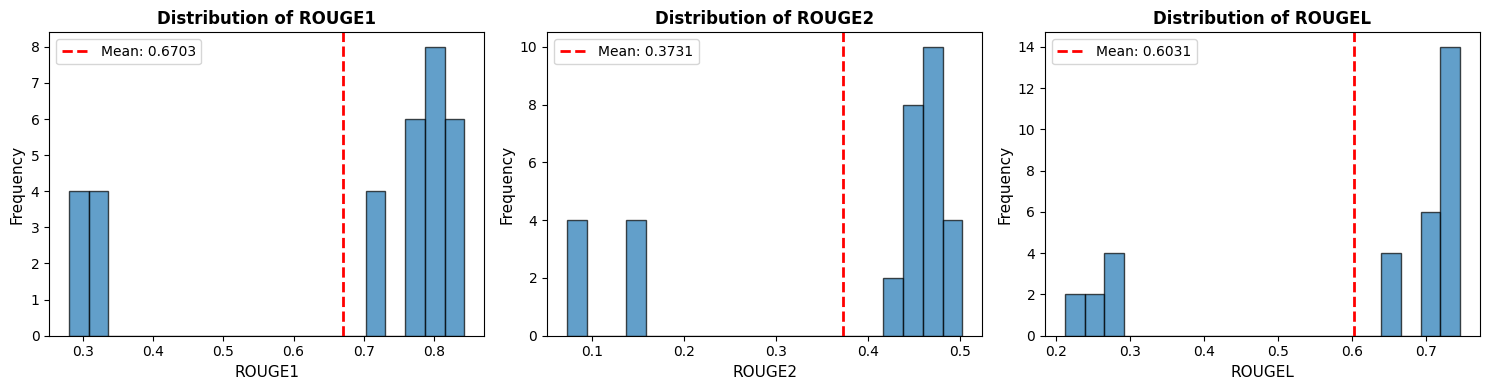

✅ Saved: top_10_comparison.png


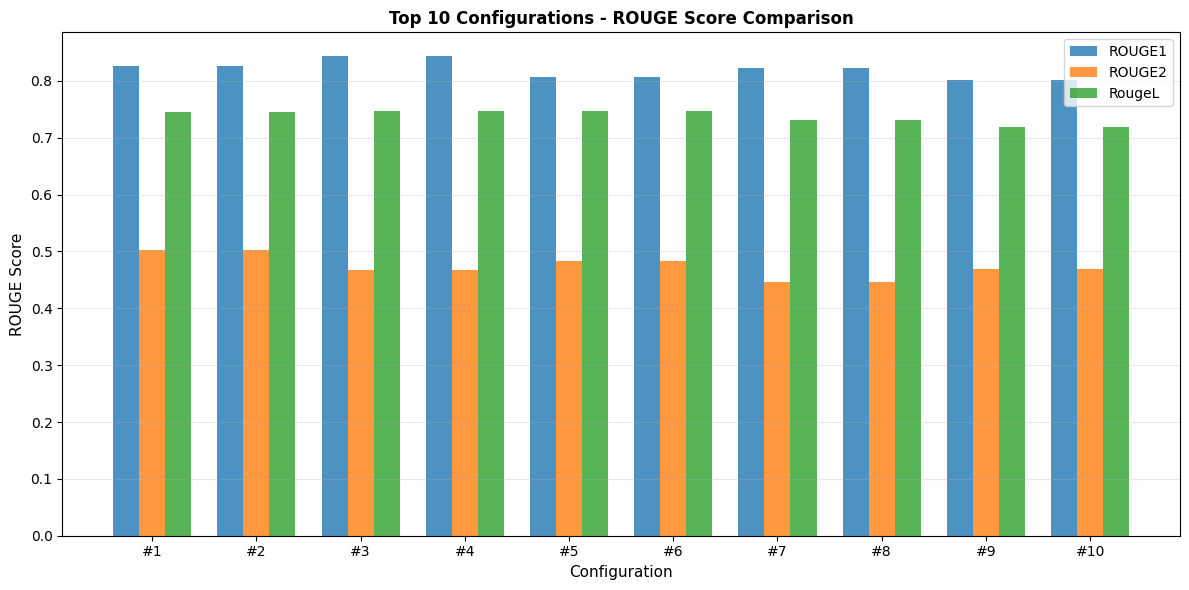

In [27]:
# 시각화 1: ROUGE 점수 분포
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, metric in enumerate(['rouge1', 'rouge2', 'rougeL']):
    axes[idx].hist(results_df[metric], bins=20, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(metric.upper(), fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Distribution of {metric.upper()}', fontsize=12, fontweight='bold')
    axes[idx].axvline(results_df[metric].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {results_df[metric].mean():.4f}')
    axes[idx].legend()

plt.tight_layout()
plt.savefig(f"{CONF['output_dir']}/rouge_distribution.png", dpi=100, bbox_inches='tight')
print("✅ Saved: rouge_distribution.png")
plt.show()

# 시각화 2: 상위 10개 설정 비교
top_10 = results_df_sorted.head(10).copy()
top_10['config_short'] = (top_10['prompt'] + '_B' + top_10['num_beams'].astype(str) + 'T' + top_10['max_tokens'].astype(str)).str[:30]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(top_10))
width = 0.25

ax.bar(x - width, top_10['rouge1'], width, label='ROUGE1', alpha=0.8)
ax.bar(x, top_10['rouge2'], width, label='ROUGE2', alpha=0.8)
ax.bar(x + width, top_10['rougeL'], width, label='RougeL', alpha=0.8)

ax.set_xlabel('Configuration', fontsize=11)
ax.set_ylabel('ROUGE Score', fontsize=11)
ax.set_title('Top 10 Configurations - ROUGE Score Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"#{i+1}" for i in range(len(top_10))], rotation=0)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONF['output_dir']}/top_10_comparison.png", dpi=100, bbox_inches='tight')
print("✅ Saved: top_10_comparison.png")
plt.show()

✅ Saved: parameter_impact.png


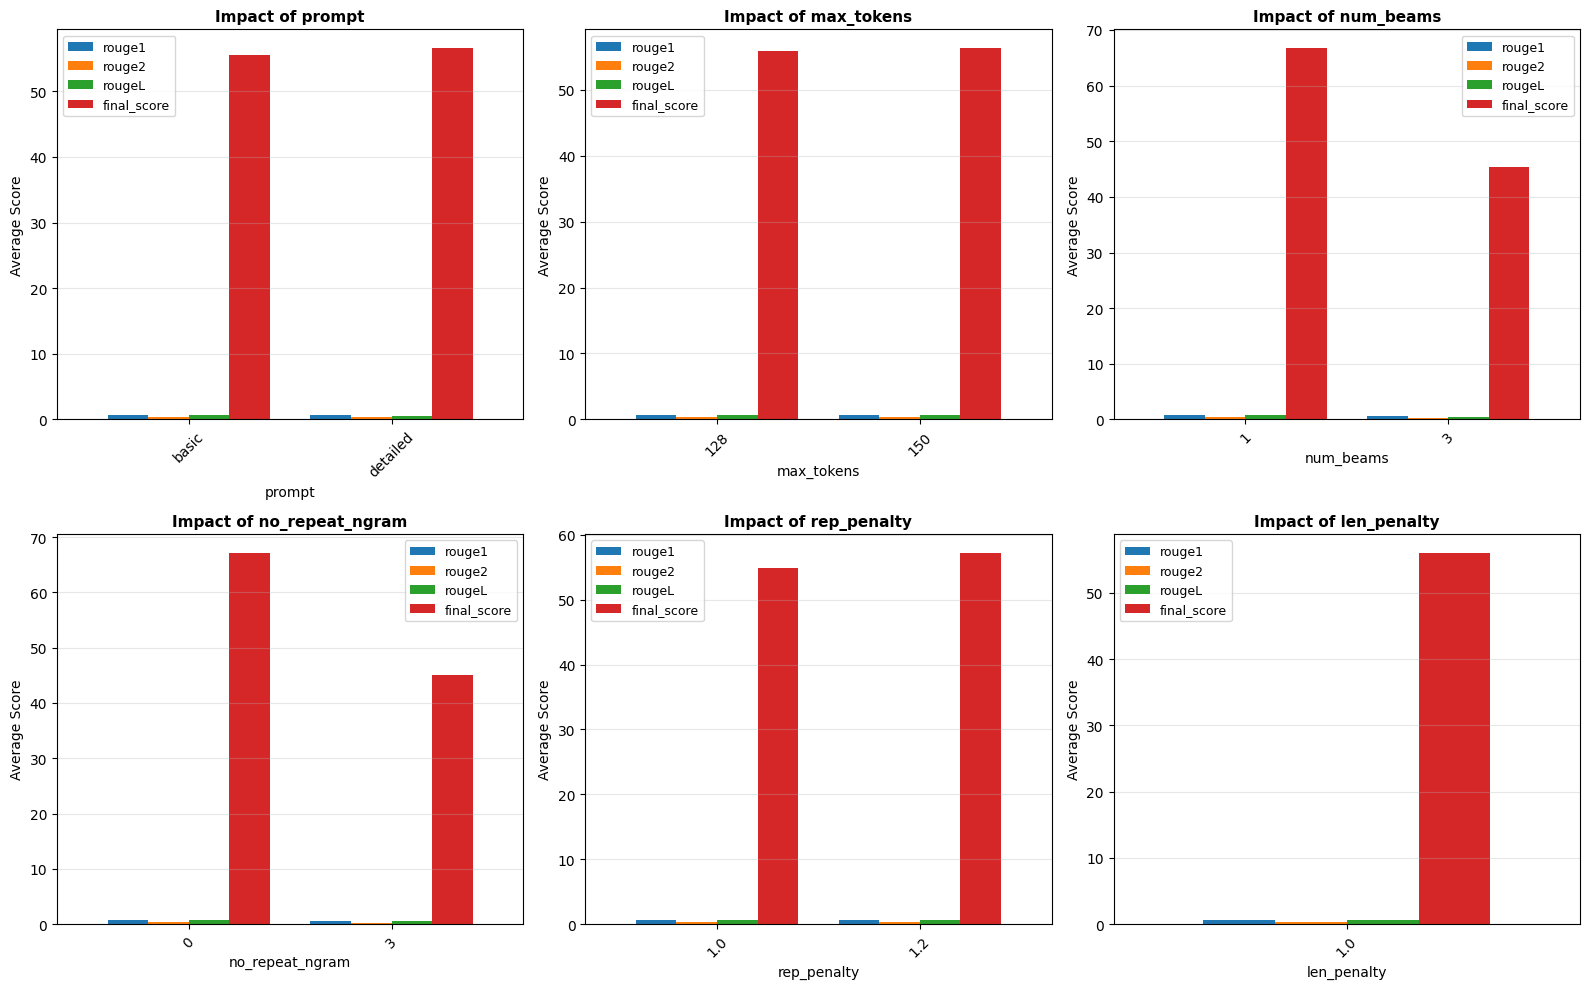

In [28]:
# 시각화 3: 파라미터 영향도 분석
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

params_to_analyze = ['prompt', 'max_tokens', 'num_beams', 'no_repeat_ngram', 'rep_penalty', 'len_penalty']

for idx, param in enumerate(params_to_analyze):
    ax = axes[idx // 3, idx % 3]
    
    param_groups = results_df.groupby(param)[['rouge1', 'rouge2', 'rougeL', 'final_score']].mean()
    param_groups.plot(kind='bar', ax=ax, width=0.8)
    
    ax.set_title(f'Impact of {param}', fontsize=11, fontweight='bold')
    ax.set_xlabel(param, fontsize=10)
    ax.set_ylabel('Average Score', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(f"{CONF['output_dir']}/parameter_impact.png", dpi=100, bbox_inches='tight')
print("✅ Saved: parameter_impact.png")
plt.show()

## 9. 최적 설정 선택 및 최종 추론

In [29]:
# 최고 성능 설정 선택
best_config = results_df_sorted.iloc[0]

print("\n" + "="*100)
print("🎯 BEST CONFIGURATION SELECTED")
print("="*100)
print(f"\nFinal Score: {best_config['final_score']:.2f}")
print(f"\nParameters:")
print(f"  • Prompt: {best_config['prompt']}")
print(f"  • Max Tokens: {best_config['max_tokens']}")
print(f"  • Num Beams: {best_config['num_beams']}")
print(f"  • No-Repeat N-gram: {best_config['no_repeat_ngram']}")
print(f"  • Repetition Penalty: {best_config['rep_penalty']}")
print(f"  • Length Penalty: {best_config['len_penalty']}")
print(f"\nROUGE Scores:")
print(f"  • ROUGE-1: {best_config['rouge1']:.4f}")
print(f"  • ROUGE-2: {best_config['rouge2']:.4f}")
print(f"  • ROUGE-L: {best_config['rougeL']:.4f}")
print("\n" + "="*100)

# 최적 설정으로 파라미터 구성
BEST_PARAMS = {
    "max_new_tokens": int(best_config['max_tokens']),
    "num_beams": int(best_config['num_beams']),
    "repetition_penalty": best_config['rep_penalty'],
    "length_penalty": best_config['len_penalty'],
}

if int(best_config['num_beams']) > 1 and int(best_config['no_repeat_ngram']) > 0:
    BEST_PARAMS["no_repeat_ngram_size"] = int(best_config['no_repeat_ngram'])

BEST_PROMPT = PROMPTS[best_config['prompt']]

print(f"\n✅ Best parameters prepared for final inference")


🎯 BEST CONFIGURATION SELECTED

Final Score: 70.52

Parameters:
  • Prompt: detailed
  • Max Tokens: 128
  • Num Beams: 3
  • No-Repeat N-gram: 0
  • Repetition Penalty: 1.2
  • Length Penalty: 1.0

ROUGE Scores:
  • ROUGE-1: 0.8269
  • ROUGE-2: 0.5026
  • ROUGE-L: 0.7455


✅ Best parameters prepared for final inference


In [30]:
# 최종 추론 (전체 테스트 셋에 최고 설정 적용)
print("\n" + "="*100)
print("🚀 FINAL INFERENCE ON TEST SET")
print("="*100)

final_summaries = []
final_start = time.time()

for dialogue in tqdm(test_df['dialogue'], desc="Test inference"):
    summary = run_inference(dialogue, BEST_PROMPT, BEST_PARAMS)
    final_summaries.append(post_process(summary))

final_elapsed = time.time() - final_start

# 제출 파일 생성
submission_df = pd.DataFrame({
    'fname': test_df['fname'],
    'summary': final_summaries
})

submission_path = f"{CONF['output_dir']}/submit_solar_gridsearch.csv"
submission_df.to_csv(submission_path, index=False)

print(f"\n✅ Inference completed in {final_elapsed/60:.1f} minutes")
print(f"✅ Results saved to: {submission_path}")
print(f"\n📊 Submission Statistics:")
print(f"  • Total summaries: {len(submission_df)}")
print(f"  • Average summary length: {submission_df['summary'].str.split().str.len().mean():.1f} words")
print(f"  • Min summary length: {submission_df['summary'].str.split().str.len().min()} words")
print(f"  • Max summary length: {submission_df['summary'].str.split().str.len().max()} words")


🚀 FINAL INFERENCE ON TEST SET


Test inference: 100%|██████████| 499/499 [9:27:34<00:00, 68.24s/it]    


✅ Inference completed in 567.6 minutes
✅ Results saved to: ./grid_search_results/submit_solar_gridsearch.csv

📊 Submission Statistics:
  • Total summaries: 499
  • Average summary length: 16.4 words
  • Min summary length: 6 words
  • Max summary length: 30 words


## 10. 최종 요약 및 메타데이터 저장

In [ ]:
# 최종 메타데이터 저장
metadata = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "grid_search_stats": {
        "total_combinations": len(results),
        "eval_sample_size": len(eval_df),
        "total_inferences": len(results) * len(eval_df),
        "grid_search_time_minutes": elapsed / 60
    },
    "best_configuration": {
        "final_score": float(best_config['final_score']),
        "prompt": best_config['prompt'],
        "max_tokens": int(best_config['max_tokens']),
        "num_beams": int(best_config['num_beams']),
        "no_repeat_ngram": int(best_config['no_repeat_ngram']),
        "repetition_penalty": float(best_config['rep_penalty']),
        "length_penalty": float(best_config['len_penalty']),
        "rouge1": float(best_config['rouge1']),
        "rouge2": float(best_config['rouge2']),
        "rougeL": float(best_config['rougeL'])
    },
    "final_inference": {
        "test_set_size": len(test_df),
        "inference_time_minutes": final_elapsed / 60,
        "submission_file": submission_path
    }
}

metadata_path = f"{CONF['output_dir']}/metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Metadata saved to: {metadata_path}")

print("\n" + "="*100)
print("📋 FINAL SUMMARY")
print("="*100)
print(f"\nGrid Search:")
print(f"  • Tested {len(results)} parameter combinations")
print(f"  • On {len(eval_df)} Dev samples")
print(f"  • Time: {elapsed/60:.1f} minutes")
print(f"\nBest Configuration:")
print(f"  • Final Score (40% R1 + 30% R2 + 30% RL): {best_config['final_score']:.2f}")
print(f"  • ROUGE1: {best_config['rouge1']:.4f} | ROUGE2: {best_config['rouge2']:.4f} | RougeL: {best_config['rougeL']:.4f}")
print(f"\nFinal Inference:")
print(f"  • Test set size: {len(test_df)}")
print(f"  • Inference time: {final_elapsed/60:.1f} minutes")
print(f"  • Submission file: {submission_path}")
print("\n" + "="*100)


✅ Metadata saved to: ./grid_search_results/metadata.json

📋 FINAL SUMMARY

Grid Search:
  • Tested 32 parameter combinations
  • On 10 Dev samples
  • Time: 189.0 minutes

Best Configuration:
  • Final Score (40% R1 + 30% R2 + 30% RL): 70.52
  • ROUGE1: 0.8269 | ROUGE2: 0.5026 | RougeL: 0.7455

Final Inference:
  • Test set size: 499
  • Inference time: 567.6 minutes
  • Submission file: ./grid_search_results/submit_solar_gridsearch.csv



: 